<a href="https://colab.research.google.com/github/falahgs/image-captioning-by-pytorch/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU openimages torch_snippets urllib3
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 133kB 7.1MB/s 
     |████████████████████████████████| 133kB 10.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 36.7MB 83kB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 6.7MB 38.6MB/s 
     |████████████████████████████████| 296kB 61.9MB/s 
     |████████████████████████████████| 137.3MB 28kB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')
np.random.shuffle(json_list)
data = []
N = 100000
for ix, json_str in Tqdm(enumerate(json_list), N):
    if ix == N: break
    try:
      result = json.loads(json_str)
      x = pd.DataFrame.from_dict(result, orient='index').T
      data.append(x)
    except:
      pass

100%|█████████▉| 99891/100000 [01:25<00:00, 1165.10it/s]

In [ ]:
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data), p=[0.95,0.05])
data.head()
data.to_csv('data.csv', index=False)

In [13]:
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2021-05-28 09:49:52.923 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-05-28 09:49:53.707 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [4]:
import pandas as pd
data = pd.read_csv('data.csv')

In [ ]:
from openimages.download import _download_images_by_id
!mkdir -p train-images val-images
subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')

subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')

In [ ]:
!pip install torchtext==0.9.0

In [10]:
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict

captions = Field(sequential=False, init_token='<start>', eos_token='<end>')
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]
captions.build_vocab(all_tokens)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
class Vocab: pass
vocab = Vocab()
captions.vocab.itos.insert(0, '<pad>')
vocab.itos = captions.vocab.itos

vocab.stoi = defaultdict(lambda: captions.vocab.itos.index('<unk>'))
vocab.stoi['<pad>'] = 0
for s,i in captions.vocab.stoi.items():
    vocab.stoi[s] = i+1

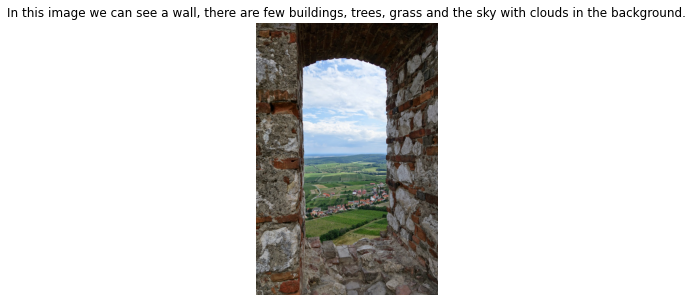

tensor([  2,   6,  15,  17,  13,  11,  10,   5, 109,   8,  14,  23,  92,  58,
         86,   7,   4,  57,  24, 169,   6,   4,  78,   3])

In [14]:
from torchvision import transforms
class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab
        self.transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))]
        )
    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        row = self.df.iloc[index].squeeze()
        id = row.image_id
        image_path = f'{self.root}/{id}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')

        caption = row.caption
        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi['<start>'])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi['<end>'])
        target = torch.Tensor(target).long()
        return image, target, caption
    def choose(self):
        return self[np.random.randint(len(self))]
    def __len__(self):
        return len(self.df)
    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)
trn_ds = CaptioningData('train-images', data[data['train']], vocab)
val_ds = CaptioningData('val-images', data[~data['train']], vocab)

image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

In [15]:
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

==================================================================

IMAGES:
Tensor  Shape: torch.Size([32, 3, 224, 224])    Min: -2.118     Max: 2.640      Mean: -0.034 
dtype: torch.float32

==================================================================

TARGETS:
Tensor  Shape: torch.Size([32, 66])     Min: 0.000      Max: 11540.000  Mean: 82.080    
dtype: torch.int64

==================================================================

LENGTHS:
Tensor  Shape: torch.Size([32]) Min: 17.000     Max: 66.000     Mean: 39.562    dtype: 
torch.int64

==================================================================

In [16]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1] # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
encoder = EncoderCNN(256).to(device)
!pip install torch_summary
from torchsummary import summary
print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-7              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-8              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-9              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-10             [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-11             [-1, 512, 28, 28]         280,064
|    └─Sequential: 2-7                   [-1, 1024, 14, 14]        --
|    |    └─Bottleneck: 3-12             [-1, 1024, 14, 14]        1,512,448
|    |    └─Bottleneck: 3-13             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-14             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-15             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-16             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-17             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-18             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-19             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-20             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-21             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-22             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-23             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-24             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-25             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-26             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-27             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-28             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-29             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-30             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-31             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-32             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-33             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-34             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-35             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-36             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-37             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-38             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-39             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-40             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-41             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-42             [-1, 1

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True) 
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1) # sampled_ids: (batch_size, max_seq_length)
        # convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab.itos[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        return sentences

In [18]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [19]:
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

In [20]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 10
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
    if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)

EPOCH: 0.338	trn_loss: 2.656	(448.46s - 12800.14s remaining)

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

@torch.no_grad()
def load_image_and_predict(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    show(org_image, title=sentence)
    return sentence

files = Glob('val-images')
for _ in range(5):
    load_image_and_predict(choose(files))
